# Desafio Analista de Data Strategy and Data Operations

## Rafael Alves Ferreira

## Desafio:

Você foi contratado por uma empresa de jogos para classificar seus jogadores em algum número de categorias de forma que eles possam organizar as partidas apenas dentro desses níveis. O objetivo principal é que as partidas sejam equilibradas - jogadores consigam partidas com jogadores de um nível de habilidade similar.
Além disso, a empresa gostaria de saber se os jogadores de algum país se destacam mais no jogo.

Você precisará extrair informações de

1. API Players : Informações pessoais dos jogadores - id, nome, e-mail, país e último login
2. PostgreSQL Matches table: Informações sobre as partidas realizadas - id, tipo de partida, jogadores participantes, data e duração
3. PostgreSQL Goals table: Informações sobre os gols feitos em cada partida - id, tempo de partida em que o gol ocorreu e jogador que fez o gol

Endereço da API
https://api.desafio.online

Credenciais do banco PostgreSQL
Usuário: readonly
Senha: desafiodsop
Host: rds.desafio.online
Banco: iclinic_games
Porta: 5432


Apresente os grupos que formar de acordo com seu método separando os nomes dos jogadores em cada categoria.
Utilize técnicas estatísticas de clusterização para justificar a resposta e apresente todos os scripts utilizados, além da argumentação em texto que julgar necessária.
Junte todos os arquivos relevantes para a sua resposta em um arquivo ZIP ou RAR, poste em algum serviço online e disponibilize o link aqui na resposta.



#### Importando as bibliotecas

In [44]:
import psycopg2 as sql
import pandas as pd
import requests
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline  

#### Verificar as tabelas na base de dados PostgreSQL

In [14]:
conn = sql.connect(database='iclinic_games',
                   host='rds.desafio.online',
                   user='readonly',
                   password='desafiodsop',
                   port=5432)
cursor = conn.cursor()

#### Verificar o esquema da tabela matches

In [15]:
qry = """SELECT
   COLUMN_NAME
FROM
   information_schema.COLUMNS
WHERE
   TABLE_NAME = 'matches';"""

cursor.execute(qry)
cursor.fetchall()

[('match_id',),
 ('match_type',),
 ('player_1',),
 ('player_2',),
 ('match_date',),
 ('match_duration',)]

#### Criar a query com os gols de cada jogador por partida

In [16]:
qry = """
select tmp1.*, tmp2.player_2, tmp2.n_goal_player_2 from
(select m.match_id
  , m.player_1
  , count(g.goal_id) as n_goal_player_1
from goals g
right outer join matches m on g.match_id=m.match_id and g.player_id=m.player_1
where m.match_id in (
  select match_id from matches where match_type = 'Ranked'
)
group by m.match_id, m.player_1) as tmp1
join (
  select m.match_id
  , m.player_2
  , count(g.goal_id) as n_goal_player_2
from goals g
right outer join matches m on g.match_id=m.match_id and g.player_id=m.player_2
where m.match_id in (
  select match_id from matches where match_type = 'Ranked'
)
group by m.match_id, m.player_2
order by match_id
) as tmp2 on tmp1.match_id=tmp2.match_id

"""
cursor.execute(qry)

In [17]:
goals_per_player_per_match = cursor.fetchall()


#### Criando um Pandas DataFrame para desenvolvimento do Dataset

In [18]:
goals_matches_per_player_df = pd.DataFrame(data=goals_per_player_per_match, 
                                           columns=['match_id', 
                                                    'player_1', 
                                                    'n_goals_player_1', 
                                                    'player_2', 
                                                    'n_goals_player_2'])
goals_matches_per_player_df.head()

,match_id,player_1,n_goals_player_1,player_2,n_goals_player_2
0,M02109295,DA1X9864,5,IA8T7256,0
1,M02109297,QX0H6977,2,PK9E7375,0
2,M02109301,AE2A5525,4,IN5D7144,0
3,M02109302,RR3I5473,2,QV8I2348,0
4,M02109303,IH1E6684,9,YX0M9945,0


##### Definindo o vencedor da partida

Verificamos o a subtração do número de gols do jogador 1 e o jogador 2. Caso o valor seja positivo, o jogador 1 foi o vencedor, caso negativo o jogador 2 foi o vencedor, em caso de empate a subtração é zero.

In [19]:
goals_matches_per_player_df['game_result'] = goals_matches_per_player_df['n_goals_player_1'] - goals_matches_per_player_df['n_goals_player_2']

In [20]:
goals_matches_per_player_df.head()

,match_id,player_1,n_goals_player_1,player_2,n_goals_player_2,game_result
0,M02109295,DA1X9864,5,IA8T7256,0,5
1,M02109297,QX0H6977,2,PK9E7375,0,2
2,M02109301,AE2A5525,4,IN5D7144,0,4
3,M02109302,RR3I5473,2,QV8I2348,0,2
4,M02109303,IH1E6684,9,YX0M9945,0,9


In [21]:
goals_matches_per_player_df['player_winner'] = goals_matches_per_player_df['player_2']

In [22]:
goals_matches_per_player_df.loc[goals_matches_per_player_df['game_result'] > 0, ['player_winner']] = goals_matches_per_player_df['player_1']

In [23]:
goals_matches_per_player_df.loc[goals_matches_per_player_df['game_result'] == 0, ['player_winner']] = 'empate'

In [24]:
goals_matches_per_player_df.head()

,match_id,player_1,n_goals_player_1,player_2,n_goals_player_2,game_result,player_winner
0,M02109295,DA1X9864,5,IA8T7256,0,5,DA1X9864
1,M02109297,QX0H6977,2,PK9E7375,0,2,QX0H6977
2,M02109301,AE2A5525,4,IN5D7144,0,4,AE2A5525
3,M02109302,RR3I5473,2,QV8I2348,0,2,RR3I5473
4,M02109303,IH1E6684,9,YX0M9945,0,9,IH1E6684


##### Transformando o jogador vitorioso em atributo (feature) por partida.

In [25]:
df1 = goals_matches_per_player_df[['match_id', 'player_1', 'n_goals_player_1', 'player_winner']]
df2 = goals_matches_per_player_df[['match_id', 'player_2', 'n_goals_player_2', 'player_winner']]
df1.rename({'player_1': 'player_id', 'n_goals_player_1': 'n_goals'}, axis=1, inplace=True)
df2.rename({'player_2': 'player_id', 'n_goals_player_2': 'n_goals'}, axis=1, inplace=True)
new_df = pd.concat([df1, df2], axis=0, ignore_index=True)

/opt/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [26]:
new_df.head()

,match_id,player_id,n_goals,player_winner
0,M02109295,DA1X9864,5,DA1X9864
1,M02109297,QX0H6977,2,QX0H6977
2,M02109301,AE2A5525,4,AE2A5525
3,M02109302,RR3I5473,2,RR3I5473
4,M02109303,IH1E6684,9,IH1E6684


#### Criando os atributos vitória (is_winner) e empate (is_draw)

In [27]:
new_df['is_winner'] = 1
new_df.loc[(new_df['player_id'] != new_df['player_winner']), ['is_winner']] = 0

In [28]:
new_df['is_draw'] = 0
new_df.loc[(new_df['player_winner'] == 'empate'), ['is_draw']] = 1

In [63]:
new_df.tail()

,match_id,player_id,n_goals,player_winner,is_winner,is_draw
99391,M02209278,CA4L1959,0,SH7R5862,0,0
99392,M02209281,RT7Q5993,0,CK7M9382,0,0
99393,M02209282,RZ5Y8389,0,LO2Q8267,0,0
99394,M02209287,FL7Q7682,0,EL1E5841,0,0
99395,M02209293,NP4L3465,0,YR2L2864,0,0


#### Trabalhando os atributos:

Criação dos agrupamentos por ID do jogados (player_id) criando as agregações:
* Número de vitórias (is_winner)
* Número de gols (n_goals)
* Número de empates (is_draw)
* Número de partidas (match_id)
* Aproveitamento dos pontos

    Hipótese 1 - Consideramos que cada vitória vale 3 pontos, empate vale 1 ponto e derrota 0 pontos.
    
    Hipótese 2 - É declarado vencedor o jogador com o maior número de gols.

In [64]:
player_rank = pd.DataFrame(new_df.groupby('player_id').agg({'is_winner': ['sum'], 'n_goals': 'sum', 'is_draw': 'sum', 'match_id': 'count'}))
player_rank = player_rank.droplevel(level=1, axis=1)
player_rank['player_points'] = player_rank['is_winner'] * 3 + player_rank['is_draw'] * 1
player_rank['aproveitamento'] = player_rank['player_points'] / (player_rank['match_id'] * 3.0)
player_rank

,is_winner,n_goals,is_draw,match_id,player_points,aproveitamento
player_id,,,,,,
AA1G9474,8,43,0,13,24,0.615385
AA1P6699,4,21,0,8,12,0.500000
AA1R9698,4,28,0,11,12,0.363636
AA1V3524,6,30,0,14,18,0.428571
AA3B3582,4,22,0,9,12,0.444444
...,...,...,...,...,...,...
ZZ7G7933,5,25,0,13,15,0.384615
ZZ8Y8845,5,19,0,8,15,0.625000
ZZ9R3591,4,26,0,10,12,0.400000


##### Baixando os dados da API

In [31]:
def get_all_players():
  """A função faz o request da API pelo máximo de 200 entradas. A API retorna os dados e o
  metadado informando se chegou ao final dos registros."""
  url = 'https://api.desafio.online'
  alist = []
  skip = 0
  while True:
    PARAMS = {'skip': skip}
    r = requests.get(url+'/v1/players/' ,params=PARAMS)
    rtn = dict(r.json())
    alist.extend(rtn['body'])
    if rtn['metadata']['has_more'] is False:
      break
    skip += 200
  return alist

In [34]:
all_players = get_all_players()
player_info = pd.DataFrame(data=all_players)
player_info.head()

,player_name,email,player_id,country,last_login
0,Trisha Kessler,trisha_kessler@gmail.com,DA1X9864,Myanmar (Burma),2020-11-12
1,Tangela Graver,tangela_g@gmail.com,SZ0S2637,Marshall Islands,2020-12-11
2,Eliseo Ewald,eliseo_ewald@gmail.com,QX0H6977,Italy,2020-12-20
3,Bernardo Dieterich,dieterich.b@gmail.com,BK3W3327,Cambodia,2020-10-11
4,Maurice Wilcoxson,wilcoxson_m@gmail.com,EG5I9716,Marshall Islands,2020-12-11


In [65]:
player_rank.reset_index(inplace=True)
player_rank = pd.merge(player_rank, player_info, how='left', on='player_id')
player_rank

,player_id,is_winner,n_goals,is_draw,match_id,player_points,aproveitamento,player_name,email,country,last_login
0,AA1G9474,8,43,0,13,24,0.615385,Mohamed Mullins,mohamed.m@yahoo.com,Tanzania,2020-11-19
1,AA1P6699,4,21,0,8,12,0.500000,Jaelynn Thornton,thornton_jaelynn@outlook.com,The Gambia,2020-10-31
2,AA1R9698,4,28,0,11,12,0.363636,Alfonso Villarreal,villarreal.a@yahoo.com,Turkmenistan,2020-12-14
3,AA1V3524,6,30,0,14,18,0.428571,Katie Mcguire,mcguire.katie@gmail.com,Central African Republic,2020-12-26
4,AA3B3582,4,22,0,9,12,0.444444,Reed Branch,branch_r@gmail.com,Tunisia,2020-12-28
...,...,...,...,...,...,...,...,...,...,...,...
9995,ZZ7G7933,5,25,0,13,15,0.384615,Abdullah Mathis,abdullah_mathis@outlook.com,Trinidad and Tobago,2020-11-03
9996,ZZ8Y8845,5,19,0,8,15,0.625000,Andrew Estes,estes.andrew@yahoo.com,Barbados,2020-11-24
9997,ZZ9R3591,4,26,0,10,12,0.400000,Ireland Turner,ireland_t@gmail.com,Afghanistan,2020-12-04
9998,ZZ9R7793,7,34,0,13,21,0.538462,Ryan Massey,massey.ryan@yahoo.com,Suriname,2020-12-08


#### Realizando o Join dos dados dos jogadores pelo player_id

In [66]:
player_rank.drop(['last_login', 'email'], axis=1, inplace=True)
player_rank

,player_id,is_winner,n_goals,is_draw,match_id,player_points,aproveitamento,player_name,country
0,AA1G9474,8,43,0,13,24,0.615385,Mohamed Mullins,Tanzania
1,AA1P6699,4,21,0,8,12,0.500000,Jaelynn Thornton,The Gambia
2,AA1R9698,4,28,0,11,12,0.363636,Alfonso Villarreal,Turkmenistan
3,AA1V3524,6,30,0,14,18,0.428571,Katie Mcguire,Central African Republic
4,AA3B3582,4,22,0,9,12,0.444444,Reed Branch,Tunisia
...,...,...,...,...,...,...,...,...,...
9995,ZZ7G7933,5,25,0,13,15,0.384615,Abdullah Mathis,Trinidad and Tobago
9996,ZZ8Y8845,5,19,0,8,15,0.625000,Andrew Estes,Barbados
9997,ZZ9R3591,4,26,0,10,12,0.400000,Ireland Turner,Afghanistan
9998,ZZ9R7793,7,34,0,13,21,0.538462,Ryan Massey,Suriname


#### Trabalhando mais atributos do Dataset:
* Média de gols por partida do jogador (goals_por_partida)
* Média de vitórias por jogo (vitoria_por_jogo)

In [67]:
player_rank['goals_por_partida'] = player_rank['n_goals'] / player_rank['match_id']
player_rank['vitoria_por_jogo'] = player_rank['is_winner'] / player_rank['match_id']
player_rank

,player_id,is_winner,n_goals,is_draw,match_id,player_points,aproveitamento,player_name,country,goals_por_partida,vitoria_por_jogo
0,AA1G9474,8,43,0,13,24,0.615385,Mohamed Mullins,Tanzania,3.307692,0.615385
1,AA1P6699,4,21,0,8,12,0.500000,Jaelynn Thornton,The Gambia,2.625000,0.500000
2,AA1R9698,4,28,0,11,12,0.363636,Alfonso Villarreal,Turkmenistan,2.545455,0.363636
3,AA1V3524,6,30,0,14,18,0.428571,Katie Mcguire,Central African Republic,2.142857,0.428571
4,AA3B3582,4,22,0,9,12,0.444444,Reed Branch,Tunisia,2.444444,0.444444
...,...,...,...,...,...,...,...,...,...,...,...
9995,ZZ7G7933,5,25,0,13,15,0.384615,Abdullah Mathis,Trinidad and Tobago,1.923077,0.384615
9996,ZZ8Y8845,5,19,0,8,15,0.625000,Andrew Estes,Barbados,2.375000,0.625000
9997,ZZ9R3591,4,26,0,10,12,0.400000,Ireland Turner,Afghanistan,2.600000,0.400000
9998,ZZ9R7793,7,34,0,13,21,0.538462,Ryan Massey,Suriname,2.615385,0.538462


#### Conclusão do desenvolvimento do Dataset:

Com os dados disponíveis nas tabelas e na API conseguimos desenvolver um Dataset final em um formato que será possível aplicar ferramentas de clusterização. Para deixar a tabela preparada para a segmentação dos jogadores definimos alguns atributos que serão os inputs para o próximo processo.

#### Clusterização:

Optamos pelo modelo k-Means pois ele oferece como vantagens:
* Relativamente simples de implementar.
* Escala para grandes conjuntos de dados.
* Garante convergência.
* Pode iniciar a quente as posições dos centróides.
* Adapta-se facilmente a novos exemplos.
* Generaliza para clusters de diferentes formas e tamanhos, como clusters elípticos.

O modelo oferece algumas desvantagens, entre elas, escolher o número de clusters manualmente. Nós contornaremos essa desvantagem ao realizar o cálculo da distorção para um intervalo de clusters e escolher o número de clusters com base nessa informação.

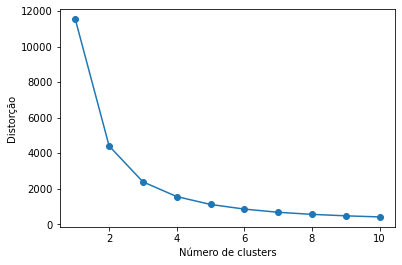

In [68]:
# calcular a distorção para um intervalo de número de clusters
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(player_rank[['aproveitamento', 'goals_por_partida', 'vitoria_por_jogo']])
    distortions.append(km.inertia_)

# plotando o gráfico
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Distorção')
plt.show()

#### Análise:
Considerando o gráfico de distorção plotado acima, percebemos que de 1 para 2 clusters temos uma significativa redução da distorção. Seguindo o gráfico, de 2 para 3 clusters ainda temos uma diminuição razoável da distorção. De 3 para 4 clusters já não percebemos grande redução da distorção em vista do custo computacional envolvido.
Neste caso, selecionamos o número de clusters como 3. Como vantagem, podemos extrapolar mais facilmente a definição de jogadores com desempenhos fraco, médio e bom.


#### Treinar o modelo:

In [69]:
kmeans = KMeans(n_clusters=3).fit(player_rank[['aproveitamento', 'goals_por_partida', 'vitoria_por_jogo']])

In [70]:
player_rank['kmeans_label'] = kmeans.labels_

In [71]:
player_rank.sort_values('player_points', ascending=False)

,player_id,is_winner,n_goals,is_draw,match_id,player_points,aproveitamento,player_name,country,goals_por_partida,vitoria_por_jogo,kmeans_label
1075,CU0Y3176,15,73,0,18,45,0.833333,Brennan Callahan,Bangladesh,4.055556,0.833333,1
9068,XP6Z1176,14,72,0,18,42,0.777778,Isla Goodwin,"Korea, North",4.000000,0.777778,1
2058,FI7G4218,14,75,0,17,42,0.823529,Zackery Fuentes,Antigua and Barbuda,4.411765,0.823529,1
2672,GY3V4432,13,57,1,23,40,0.579710,Alessandra Dunlap,Turkey,2.478261,0.565217,0
5244,NQ3N7447,13,81,1,16,40,0.833333,Makena Aguilar,Guinea,5.062500,0.812500,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5009,NB8F2883,0,0,0,3,0,0.000000,Amira Wilkins,France,0.000000,0.000000,2
9287,YF5T9684,0,0,0,3,0,0.000000,Aaden Mcdowell,Andorra,0.000000,0.000000,2
3822,JY3R2414,0,0,0,5,0,0.000000,Mauricio Jefferson,Nauru,0.000000,0.000000,2
5983,PN4V5575,0,0,0,2,0,0.000000,Izayah Huffman,Belgium,0.000000,0.000000,2


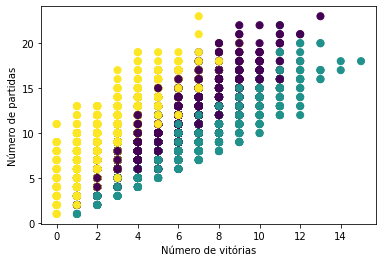

In [72]:
y_kmeans = player_rank[['kmeans_label']].values
plt.scatter(player_rank.loc[:, 'is_winner'], player_rank.loc[:, 'match_id'], c=y_kmeans, s=50, cmap='viridis')
plt.xlabel('Número de vitórias')
plt.ylabel('Número de partidas')
plt.show()

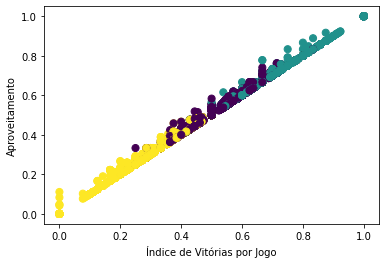

In [73]:
y_kmeans = player_rank[['kmeans_label']].values
plt.scatter(player_rank.loc[:, 'vitoria_por_jogo'], player_rank.loc[:, 'aproveitamento'], c=y_kmeans, s=50, cmap='viridis')
plt.xlabel('Índice de Vitórias por Jogo')
plt.ylabel('Aproveitamento')
plt.show()

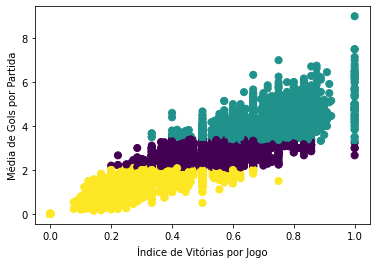

In [74]:
y_kmeans = player_rank[['kmeans_label']].values
plt.scatter(player_rank.loc[:, 'vitoria_por_jogo'], player_rank.loc[:, 'goals_por_partida'], c=y_kmeans, s=50, cmap='viridis')
plt.xlabel('Índice de Vitórias por Jogo')
plt.ylabel('Média de Gols por Partida')
plt.show()

#### Análise:

Percebemos que fica claro a segmentação dos jogadores em três clusters, podendo classificar os jogadores com desempenho fraco, médio e bom.
Os bons jogadores conseguem maiores números de vitórias com menos partidas, tem uma relação linear de índice de vitórias por jogo com o aproveitamento dos pontos e tem uma média de gols por partida maior. O inverso é válido para os jogadores com desempenho fraco.

#### Lista do grupo de jogadores com bom desempenho (verde)

In [104]:
player_rank.loc[(player_rank['kmeans_label'] == 1)]['player_name']

5         Jaylee Campbell
6             Averi Pratt
15        Courtney Sutton
16           Janae Hebert
20             Diya Cowan
              ...        
9976        Kieran Nelson
9981         Dale Baldwin
9988      Jaxson Richards
9989    Kirsten Donaldson
9993      Kendall Proctor
Name: player_name, Length: 2320, dtype: object

#### Lista do grupo de jogadores com desempenho médio (roxo)

In [101]:
player_rank.loc[(player_rank['kmeans_label'] == 0)]['player_name']

0          Mohamed Mullins
1         Jaelynn Thornton
2       Alfonso Villarreal
3            Katie Mcguire
4              Reed Branch
               ...        
9990        Yandel Wallace
9994            Reyna Hart
9996          Andrew Estes
9997        Ireland Turner
9998           Ryan Massey
Name: player_name, Length: 4662, dtype: object

#### Lista do grupo de jogadores com desempenho fraco (amarelo)

In [106]:
player_rank.loc[player_rank['kmeans_label'] == 2]['player_name'].sort_values()

244           Aaden Byrd
9287      Aaden Mcdowell
6835      Aaliyah Forbes
516     Aaliyah Lawrence
1209         Aaron Hines
              ...       
1602         Zoey Levine
7382           Zoey Wise
8237          Zoie Avery
4328          Zoie Duffy
221          Zoie Vargas
Name: player_name, Length: 3018, dtype: object

#### País com desempenho relevante:

In [105]:
player_rank[player_rank['kmeans_label'] == 1].groupby('country')['kmeans_label'].count().sort_values(ascending=False)

country
Syria                                24
Angola                               20
Brunei                               19
Eswatini                             19
Sudan                                18
Lithuania                            18
Chad                                 18
Sierra Leone                         18
Australia                            18
Guatemala                            17
Togo                                 17
Sweden                               17
Fiji                                 17
Turkmenistan                         17
Rwanda                               17
Latvia                               17
Azerbaijan                           17
Morocco                              17
Burundi                              17
Romania                              17
Croatia                              16
Singapore                            16
Canada                               16
Marshall Islands                     16
Ireland                         

Podemos perceber que a Síria é o país que tem o maior número de jogadores no grupo com bom desempenho, podendo ser considerado um país de destaque.